IMPORTING LIBRARIES

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# To generate wordclouds
from wordcloud import WordCloud, STOPWORDS

# To show images
from PIL import Image

# For stemming and lemmatising
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

# To compute the confusion matrix
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ee121\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ee121\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


CLASS TO REPRESENT NAIVE BAYE'S MODELS

In [35]:
# Represents a Naive Baye's classification model
class Naive_Bayes:

    '''
    training_data: np.ndarray | numpy array containing all the training data - labels and documents
    label_selector: string | defines the probability distribution used to predict label during inference | MULTINOULLI, RANDOM, POSITIVE
    data_formatter: function | defines how the training data is modified | returns labels and documents | format_data, format_data_stemming
    features: defines what features to use in the model | UNIGRAM, BIGRAM, 
    '''
    
    def __init__(self, training_data, data_formatter, feature_mode, smoothening_param):
                
        # Dictionary to map label to total length of all documents of that label
        self.total_label_len = {"Positive": 0, "Negative": 0, "Neutral": 0}

        # Dictionary to map label to number of documents of that label
        self.label_freq = {"Positive": 0, "Negative": 0, "Neutral": 0}

        # Vocabulary for this model
        self.vocab = {}

        # number of words in vocabulary
        self.vocab_len = 0

        # parameters of multinoulli distribution if labels are distributed using multinoulli distribution
        # Keys - Positive, Negative, Neutral
        self.phi = {}

        # parameters of multinoulli distrbution considering all parameters are distributed using multinoulli distribution
        # Keys - every word from vocabulary
        # Values - dictionary mapping label to corresponding parameter
        self.word_params = {}

        # Smoothening parameter for Laplace Smoothening
        self.alpha = smoothening_param

        self.training_data = training_data
        self.training_docs, self.training_labels = data_formatter(training_data)
        self.m = self.training_docs.shape[1]        # number of training examples

        # determines what to keep as features
        self.feature_mode = feature_mode

        self.create_vocabulary()            # creates the vocabulary
        self.estimate_parameters()          # estimates all the parameters (assumes labels to be represented using multinoulli distribution)

    # creates the vocabulary from training documents
    # also computes the number of documents and total length of documents of each label
    def create_vocabulary(self):
        # iterates over all the documents
        for i in range(self.m):
            label = self.training_labels[0][i]
            doc = self.training_docs[0][i]
            
            words = doc.split()     # splits the sentence into words using space as delimiter

            self.label_freq[label] += 1
            self.total_label_len[label] += len(words)
            
            # iterates over every word in this document
            # inserts the word into dictionary and if already present increases its frequency for the corresponding label
            for word in words:
                if word not in self.vocab.keys():
                    self.vocab[word] = {"Positive": 0, "Negative": 0, "Neutral": 0}
                self.vocab[word][label] += 1

            # if consecutive words are also treated as a feature
            if self.feature_mode == 'BIGRAM':
                for i in range(len(words)-1):
                    feature = words[i] + ' ' + words[i+1]
                    if feature not in self.vocab.keys():
                        self.vocab[feature] = {"Positive": 0, "Negative": 0, "Neutral": 0}
                    self.vocab[feature][label] += 1
            elif self.feature_mode == '3GRAM':
                for i in range(len(words)-1):
                    feature = words[i] + ' ' + words[i+1]
                    if feature not in self.vocab.keys():
                        self.vocab[feature] = {"Positive": 0, "Negative": 0, "Neutral": 0}
                    self.vocab[feature][label] += 1
                for i in range(len(words)-2):
                    feature = words[i] + ' ' + words[i+1] + ' ' + words[i+2]
                    if feature not in self.vocab.keys():
                        self.vocab[feature] = {"Positive": 0, "Negative": 0, "Neutral": 0}
                    self.vocab[feature][label] += 1
       
        self.vocab_len = len(self.vocab)

    # estimates the parameter of the model
    # assumes labels to be selected using multinoulli distribution
    # assumes bag-of-words model and each position is associated with the same multinoulli distribution
    def estimate_parameters(self):

        # Compute phi parameters used to select label
        phi_pos = (self.label_freq["Positive"]) / (self.m)
        phi_neg = (self.label_freq["Negative"]) / (self.m)
        phi_neu = (self.label_freq["Neutral"]) / (self.m)

        self.phi = {"Positive": phi_pos, "Negative": phi_neg, "Neutral": phi_neu}

        # Compute theta parameters used to select a word at a particular position
        for word in self.vocab:
            pos_freq = self.vocab[word]["Positive"]
            neg_freq = self.vocab[word]["Negative"]
            neu_freq = self.vocab[word]["Neutral"]

            pos_param = (pos_freq + self.alpha) / (self.total_label_len["Positive"] + self.vocab_len*self.alpha)
            neg_param = (neg_freq + self.alpha) / (self.total_label_len["Negative"] + self.vocab_len*self.alpha)
            neu_param = (neu_freq + self.alpha) / (self.total_label_len["Neutral"] + self.vocab_len*self.alpha)

            self.word_params[word] = {"Positive": pos_param, "Negative": neg_param, "Neutral": neu_param}

    # Returns the log probability of a word being present at any position given the label of the document
    def compute_x_given_y(self, doc, label):
        log_prob = 0
        words = doc.split()

        for word in words:
            # Ignores the words which are not a part of vocabulary
            if word in self.vocab.keys():
                log_prob += np.log(self.word_params[word][label])
    
        # if we use consecutive words as a feature
        if self.feature_mode == 'BIGRAM':
            for i in range(len(words)-1):
                feature = words[i] + ' ' + words[i+1]
                if feature in self.vocab:
                    log_prob += np.log(self.word_params[feature][label])
        elif self.feature_mode == '3GRAM':
            for i in range(len(words)-1):
                feature = words[i] + ' ' + words[i+1]
                if feature in self.vocab:
                    log_prob += np.log(self.word_params[feature][label])
            for i in range(len(words)-2):
                feature = words[i] + ' ' + words[i+1] + ' ' + words[i+2]
                if feature in self.vocab:
                    log_prob += np.log(self.word_params[feature][label])            
                
        return log_prob
    
    # Returns a np array of the predictions made by our model for each document
    def get_inference(self, docs):
        inference = []

        for i in range(docs.shape[1]):
            doc = docs[0][i]

            # Computes probability of x|y for each label depending on the label_selector function
            pos_prob = self.compute_x_given_y(doc, "Positive") + np.log(self.phi["Positive"])
            neg_prob = self.compute_x_given_y(doc, "Negative") + np.log(self.phi["Negative"])
            neu_prob = self.compute_x_given_y(doc, "Neutral") + np.log(self.phi["Neutral"])

            # Determines which label has highest probability
            max_value = max(pos_prob, neg_prob, neu_prob)

            if max_value == neu_prob:
                inference.append("Neutral")
            elif max_value == neg_prob:
                inference.append("Negative")
            else:
                inference.append("Positive")
        
        return np.array(inference, ndmin=2)

STOPWORDS FOR THE DATA

In [16]:
# Extends STOPWORDS set to include noisy and redundant words
# Such words include http, some noisy words and variations of covid and coronavirus
alphabets = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
stopwords = STOPWORDS.union(['http', 'https', 'will', 't', 'co', 'coronavirus', 'COVID', 'COVID19', 'Covid-19', 'Covid_19'])
stopwords = stopwords.union(alphabets)

BASIC FORMATTING

In [17]:
# Does not perform stemming or lemmatisation
def format_data_basic(data):
    m = data.shape[1]
    labels = data[1].reshape((1, m))
    docs = data[2].reshape((1, m))
    return docs, labels

PART - A <br>
INFERENCE AND ACCURACY OVER TRAINING AND VALIDATION SETS

In [18]:
# Reading training and validation CSV files
training_data_1 = pd.read_csv('Corona_train.csv').to_numpy().T
validation_data_1 = pd.read_csv('Corona_validation.csv').to_numpy().T

# Getting the training documents and labels
training_docs_1, training_labels_1 = format_data_basic(training_data_1)

# Getting labels and documents from validation set
validation_docs_1, validation_labels_1 = format_data_basic(validation_data_1)
validation_examples_1 = validation_docs_1.shape[1]      # Number of examples in validation set

# Learning the model
# Smoothening param is fixed after trying with different values
model_1 = Naive_Bayes(training_data_1, format_data_basic, 'UNIGRAM', 0.6)

# Predicting the labels for both training and validation set using learnt parameters
inference_training_1 = model_1.get_inference(model_1.training_docs)
inference_validation_1 = model_1.get_inference(validation_docs_1)

# Computing accuracy over training and validation sets
accuracy_training_1 = (np.sum(inference_training_1 == model_1.training_labels)) / (model_1.m)
accuracy_validation_1 = (np.sum(inference_validation_1 == validation_labels_1)) / (validation_examples_1)

accuracy_training_1, accuracy_validation_1

(0.8882579759137967, 0.6738536289098087)

PART_A <br>
CREATING THE WORDCLOUD FOR EACH CLASS USING TRAINING SET

In [19]:
# maps the concatenated text from all the documents for each label
label_text = {"Positive": "", "Negative": "", "Neutral": ""}

# fills the label_text dictionary
for i in range(model_1.m):
    label = model_1.training_labels[0][i]
    doc = model_1.training_docs[0][i]
    label_text[label] = " ".join([label_text[label], doc])

def create_wordcloud(text):
    wordcloud = WordCloud(background_color='white', height=600, width=400, stopwords=stopwords)
    wordcloud.generate(text)
    return wordcloud

# Wordcloud for each label
word_cloud_pos = create_wordcloud(label_text["Positive"])
word_cloud_neg = create_wordcloud(label_text["Negative"])
word_cloud_neu = create_wordcloud(label_text["Neutral"])

# Saves the created wordclouds to PNG files
word_cloud_pos.to_file('wc-pos.png')
word_cloud_neg.to_file('wc-neg.png')
word_cloud_neu.to_file('wc-neu.png')

# To show an image, use -
# wc_pos = Image.open('wc-pos.png')
# wc_neg = Image.open('wc-neg.png')
# wc_neu = Image.open('wc-neu.png')
# wc_pos.show()
# wc_neg.show()
# wc_neu.show()

PART-B

In [20]:
inference_training_random = []                  # Predictions on training set with random guess
inference_training_positive = []                # Predictions on validation set with random guess
inference_validation_random = []                # Predictions on training set with always positive guess
inference_validation_positive = []              # Predictions on validation set with always positive guess

# Fills the training and validation predictions with random guesses
for i in range(training_docs_1.shape[1]):
    label = np.random.choice(['Positive', 'Negative', 'Neutral'])
    inference_training_random.append(label)
    inference_training_positive.append("Positive")

# Fills the training and validation predictions with always positive guesses
for i in range(validation_examples_1):
    label = np.random.choice(['Positive', 'Negative', 'Neutral'])
    inference_validation_random.append(label)
    inference_validation_positive.append("Positive")

inference_training_random = np.array(inference_training_random, ndmin=2)
inference_training_positive = np.array(inference_training_positive, ndmin=2)

inference_validation_random = np.array(inference_validation_random, ndmin=2)
inference_validation_positive = np.array(inference_validation_positive, ndmin=2)

# Computing accuracy over validation sets
accuracy_validation_random = (np.sum(inference_validation_random == validation_labels_1)) / (validation_examples_1)
accuracy_validation_positive = (np.sum(inference_validation_positive == validation_labels_1)) / (validation_examples_1)

accuracy_validation_random, accuracy_validation_positive

(0.3270573944731248, 0.4385059216519891)

PART-C <br>CONFUSION MATRIX

In [23]:
# Converts an array with labels 'Positive', 'Negative' and 'Neutral' to array with labels 0, 1 and 2 respectively 
def convert_labels_into_ints(x):
    x = x.flatten()
    y = []
    for i in range(x.shape[0]):
        if x[i] == 'Positive':
            y.append(0)
        elif x[i] == 'Negative':
            y.append(1)
        else:
            y.append(2)

    return y

# Confusion matrix for training and validation sets for multinoulli distributed labels
cm_train_nb = confusion_matrix(convert_labels_into_ints(training_labels_1), convert_labels_into_ints(inference_training_1))
cm_valid_nb = confusion_matrix(convert_labels_into_ints(validation_labels_1), convert_labels_into_ints(inference_validation_1))

# Confusion matrix for training and validation sets for randomly guessed labels
cm_train_rand = confusion_matrix(convert_labels_into_ints(training_labels_1), convert_labels_into_ints(inference_training_random))
cm_valid_rand = confusion_matrix(convert_labels_into_ints(validation_labels_1), convert_labels_into_ints(inference_validation_random))

# Confusion matrix for training and validation sets for always positive guessed labels
cm_train_pos = confusion_matrix(convert_labels_into_ints(training_labels_1), convert_labels_into_ints(inference_training_positive))
cm_valid_pos = confusion_matrix(convert_labels_into_ints(validation_labels_1), convert_labels_into_ints(inference_validation_positive))

cm_train_nb, cm_valid_nb, cm_train_rand, cm_valid_rand, cm_train_pos, cm_valid_pos

(array([[15738,   668,   196],
        [  771, 13207,   188],
        [ 1390,  1018,  4688]], dtype=int64),
 array([[1151,  256,   37],
        [ 275,  926,   31],
        [ 292,  183,  142]], dtype=int64),
 array([[5541, 5486, 5575],
        [4844, 4712, 4610],
        [2377, 2388, 2331]], dtype=int64),
 array([[480, 501, 463],
        [401, 402, 429],
        [213, 209, 195]], dtype=int64),
 array([[16602,     0,     0],
        [14166,     0,     0],
        [ 7096,     0,     0]], dtype=int64),
 array([[1444,    0,    0],
        [1232,    0,    0],
        [ 617,    0,    0]], dtype=int64))

FORMATTING INCLUDING STOPWORD REMOVAL AND STEMMING/LEMMATISING

In [24]:
# Function to format the data and modify it using stopword removal and lemmatising
def format_data_lemmatising(data):
    m = data.shape[1]
    labels = data[1].reshape((1, m))
    docs = data[2].reshape((1, m))
    
    # List of punctuation marks which may appear in the document
    punctuations = ['.', ',', '$', '@', '#', '/', ':', ';', '&', '~', '(', ')', '[', ']', '{', '}', '-']
    
    # We iterate over every document and format it
    for i in range(m):
        doc = docs[0][i]
        
        # Removing the punctuation marks
        temp=''
        for char in doc:
            if char not in punctuations:
                temp = temp + char
            else:
                temp = temp + ' '
        doc = temp

        # Changing all characters to lowercase
        doc = doc.lower()
        # tokenizer = nltk.tokenize.TreebankWordTokenizer()
        # tokens = tokenizer.tokenize(doc)
        tokens = doc.split()

        # Lemmatising the words
        lemmatiser = nltk.stem.WordNetLemmatizer()
        doc = [lemmatiser.lemmatize(token) for token in tokens]
        
        # Stopword Removal
        final_doc = []
        for word in doc:
            if word not in stopwords:
                final_doc.append(word)
        
        # Final document after modification
        docs[0][i] = " ".join(final_doc)
    
    return docs, labels

PART-D <br>
LEARNING THE MODEL AFTER PERFORMING STEMMING

In [25]:
model_2 = Naive_Bayes(training_data_1, format_data_lemmatising, 'UNIGRAM', 0.4)
# For smoothening_param < 0.4, training accuracy increases but validation accuracy decreases

# Getting labels and documents from validation set
validation_docs_2, validation_labels_2 = format_data_lemmatising(validation_data_1)
validation_examples_2 = validation_docs_2.shape[1]      # Number of examples in validation set

# Predicting the labels for both training and validation set using learnt parameters
inference_training_2 = model_2.get_inference(model_2.training_docs)
inference_validation_2 = model_2.get_inference(validation_docs_2)

# Computing accuracy over training and validation sets
accuracy_training_2 = (np.sum(inference_training_2 == model_2.training_labels)) / (model_2.m)
accuracy_validation_2 = (np.sum(inference_validation_2 == validation_labels_2)) / validation_examples_2

accuracy_training_2, accuracy_validation_2

(0.8915064441157828, 0.691163073185545)

PART-D <br>
WORDCLOUDS FOR LEMMATISED DOCUMENTS

In [26]:
label_text_lemmatised = {"Positive": "", "Negative": "", "Neutral": ""}

# fills the label_text dictionary
for i in range(model_2.m):
    label = model_2.training_labels[0][i]
    doc = model_2.training_docs[0][i]
    label_text_lemmatised[label] = " ".join([label_text_lemmatised[label], doc])

# Wordcloud for each label
word_cloud_pos_lemm = create_wordcloud(label_text_lemmatised["Positive"])
word_cloud_neg_lemm = create_wordcloud(label_text_lemmatised["Negative"])
word_cloud_neu_lemm = create_wordcloud(label_text_lemmatised["Neutral"])

# Saves the created wordclouds to PNG files
word_cloud_pos_lemm.to_file('wc-pos-l.png')
word_cloud_neg_lemm.to_file('wc-neg-l.png')
word_cloud_neu_lemm.to_file('wc-neu-l.png')

PART-E <br>
USING BI-GRAMS AS FEATURES

In [46]:
# Using bigrams in addition to unigrams as features
model_3 = Naive_Bayes(training_data_1, format_data_lemmatising, 'BIGRAM', 1.2)

# Predicting the labels for both training and validation set using learnt parameters
inference_training_3 = model_3.get_inference(model_3.training_docs)
inference_validation_3 = model_3.get_inference(validation_docs_2)

# Computing accuracy over training and validation sets
accuracy_training_3 = (np.sum(inference_training_3 == model_3.training_labels)) / (model_3.m)
accuracy_validation_3 = (np.sum(inference_validation_3 == validation_labels_2)) / validation_examples_2

accuracy_training_3, accuracy_validation_3

(0.8973695330657089, 0.6529000911023383)

PART-E <br>
ANOTHER FEATURE SCHEME - 

In [50]:
model_4 = Naive_Bayes(training_data_1, format_data_lemmatising, '3GRAM', 0.8)

# Predicting the labels for both training and validation set using learnt parameters
inference_training_4 = model_4.get_inference(model_4.training_docs)
inference_validation_4 = model_4.get_inference(validation_docs_2)

# Computing accuracy over training and validation sets
accuracy_training_4 = (np.sum(inference_training_4 == model_4.training_labels)) / (model_4.m)
accuracy_validation_4 = (np.sum(inference_validation_4 == validation_labels_2)) / validation_examples_2

accuracy_training_4, accuracy_validation_4

(0.9777361081766321, 0.6544184634072274)

PART-F <br>
DOMAIN ADAPTATION

In [31]:
# Validation data (target domain)
target_validation_data = pd.read_csv('Twitter_validation.csv').to_numpy().T
target_validation_docs, target_validation_labels = format_data_lemmatising(target_validation_data)
target_validation_examples = target_validation_labels.shape[1]

# Computes the accuracy over the validation set when source data is used/not used along with 'target_training_file_name' for training
# mode : with = source data used | without = source data not used
def domain_adaptation_accuracy(target_training_file_name, mode):
    
    target_training_data = pd.read_csv(target_training_file_name).to_numpy().T
    
    # Concatenates the target training data with source data if mode is 'with'
    if mode=='with':
        training_data = np.concatenate((training_data_1, target_training_data), axis=1)
    # Else training data consists of target training data only
    else:
        training_data = target_training_data
    
    # Learns the Naive Baye's model on the training data (after lemmatisation) using unigram features
    model = Naive_Bayes(training_data, format_data_lemmatising, 'UNIGRAM', 1)
    
    # Gets the inference on the validation set
    inference = model.get_inference(target_validation_docs)

    # Computes the accuracy over validation set
    accuracy = (np.sum(inference == target_validation_labels)) / (target_validation_examples)

    return accuracy

# Accuracy for domain adaptation models using source data
accuracy_1 = domain_adaptation_accuracy('Twitter_train_1.csv', 'with')
accuracy_2 = domain_adaptation_accuracy('Twitter_train_2.csv', 'with')
accuracy_5 = domain_adaptation_accuracy('Twitter_train_5.csv', 'with')
accuracy_10 = domain_adaptation_accuracy('Twitter_train_10.csv', 'with')
accuracy_25 = domain_adaptation_accuracy('Twitter_train_25.csv', 'with')
accuracy_50 = domain_adaptation_accuracy('Twitter_train_50.csv', 'with')
accuracy_100 = domain_adaptation_accuracy('Twitter_train_100.csv', 'with')

# Accuracy for domain adaptation models not using source data
accuracy_1_wo = domain_adaptation_accuracy('Twitter_train_1.csv', 'without')
accuracy_2_wo = domain_adaptation_accuracy('Twitter_train_2.csv', 'without')
accuracy_5_wo = domain_adaptation_accuracy('Twitter_train_5.csv', 'without')
accuracy_10_wo = domain_adaptation_accuracy('Twitter_train_10.csv', 'without')
accuracy_25_wo = domain_adaptation_accuracy('Twitter_train_25.csv', 'without')
accuracy_50_wo = domain_adaptation_accuracy('Twitter_train_50.csv', 'without')
accuracy_100_wo = domain_adaptation_accuracy('Twitter_train_100.csv', 'without')

accuracy_1_wo, accuracy_2_wo, accuracy_5_wo, accuracy_10_wo, accuracy_25_wo, accuracy_50_wo, accuracy_100_wo, accuracy_1, accuracy_2, accuracy_5, accuracy_10, accuracy_25, accuracy_50, accuracy_100

(0.3724320742213386,
 0.37475149105367794,
 0.4304174950298211,
 0.46355202120609673,
 0.4638833664678595,
 0.5059642147117296,
 0.5444002650762094,
 0.41915175612988737,
 0.4280980781974818,
 0.43505632869449967,
 0.44201457919151754,
 0.46421471172962225,
 0.4990059642147117,
 0.5410868124585818)

PART-F <br>
PLOTTING THE ACCURACIES

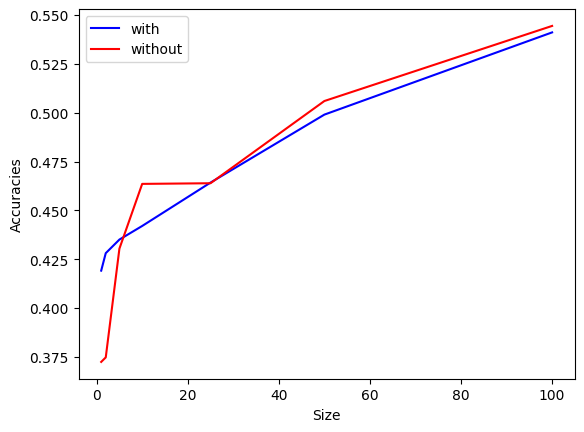

In [32]:
# Plots the accuracies of the models using and not using the source data as we increase the size of the target training data

size_target_train_data = [1, 2, 5, 10, 25, 50, 100]

accuracies_with = [accuracy_1, accuracy_2, accuracy_5, accuracy_10, accuracy_25, accuracy_50, accuracy_100]
accuracies_without = [accuracy_1_wo, accuracy_2_wo, accuracy_5_wo, accuracy_10_wo, accuracy_25_wo, accuracy_50_wo, accuracy_100_wo]

plt.plot(size_target_train_data, accuracies_with, label='with', color='blue')
plt.plot(size_target_train_data, accuracies_without, label='without', color='red')

plt.xlabel('Size')
plt.ylabel('Accuracies')
plt.legend()